<a href="https://colab.research.google.com/github/therishabhmittal-05/music/blob/main/NonSpeech7k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

therishabhmittal05_nonspeech7kds_path = kagglehub.dataset_download('therishabhmittal05/nonspeech7kds')

print('Data source import complete.')


In [ ]:
# ! /kaggle/input/nonspeech7kds

In [ ]:
# !unzip /kaggle/input/nonspeech7kds/nonspeech7k.zip

In [ ]:
import pandas as pd
import numpy as np
import torch
import librosa
import cv2
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
ds = pd.read_csv("/kaggle/input/nonspeech7kds/nonspeech7k/metadataoftrainset.csv")
ds.head()

,Filename,File ID,Duration in ms,Class ID,Classname,augmentation id,Augmentation type,source
0,108160-1_0_0.wav,108160,3730,0,breath,0,Orignal,https://freesound.org/
1,108160-2_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
2,108160-3_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/
3,108160-4_0_0.wav,108160,2226,0,breath,0,Orignal,https://freesound.org/
4,146769-1_0_0.wav,146769,3540,0,breath,0,Orignal,https://freesound.org/


In [ ]:
class_ind = {
    'breath' : 0,
    'cough' : 1,
    'crying' : 2,
    'laugh' : 3,
    'screaming' : 4,
    'sneeze' : 5,
    'yawn' : 6
}
def class_index(ds):
  ds['label'] = ds.Classname.map(class_ind)

class_index(ds)
n_labels = len(class_ind)

In [ ]:
ds.head()

,Filename,File ID,Duration in ms,Class ID,Classname,augmentation id,Augmentation type,source,label
0,108160-1_0_0.wav,108160,3730,0,breath,0,Orignal,https://freesound.org/,0
1,108160-2_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/,0
2,108160-3_0_0.wav,108160,4000,0,breath,0,Orignal,https://freesound.org/,0
3,108160-4_0_0.wav,108160,2226,0,breath,0,Orignal,https://freesound.org/,0
4,146769-1_0_0.wav,146769,3540,0,breath,0,Orignal,https://freesound.org/,0


In [ ]:
# ls /kaggle/input/nonspeech7kds/nonspeech7k/train/train

In [ ]:
class config:
  in_dir = "/kaggle/input/nonspeech7kds/nonspeech7k/train/train/"
  out_dir = "/kaggle/working/mel_spectrograms/"
  sr = 32000
  n_fft = 1024
  hop_length = 256
  n_mels = 128
  fmin = 20
  fmax = 16000
  t_shape = (256, 256)

In [ ]:
# import IPython.display as ip
# audio = config.in_dir + ds.Filename[0]
# label = ds.Classname[0]
# print(label)
# print(audio)
# ip.Audio(audio)

In [ ]:
# y, sr = librosa.load(audio)

# mel = librosa.feature.melspectrogram(
#     y=y,
#     sr = config.sr,
#     n_fft = config.n_fft,
#     hop_length = config.hop_length,
#     n_mels = config.n_mels,
#     fmin = config.fmin,
#     fmax = config.fmax
# )
# mel = librosa.power_to_db(mel, ref = np.max)
# librosa.display.specshow(mel)
# print(label)
# print(mel.shape)

In [ ]:
# mel = get_mel(audio)
# librosa.display.specshow(mel)

In [ ]:
def get_mel(y):
  mel = librosa.feature.melspectrogram(
      y=y,
      sr = config.sr,
      n_fft = config.n_fft,
      hop_length = config.hop_length,
      n_mels = config.n_mels,
      fmin = config.fmin,
      fmax = config.fmax
  )
  mel = librosa.power_to_db(mel, ref = np.max)
  mel = (mel - mel.min()) / (mel.max() - mel.min() + 1e-8)
  return mel

In [ ]:
os.makedirs(config.out_dir, exist_ok=True)
for i, row in tqdm(ds.iterrows(), total=len(ds)):
  audio = config.in_dir + row.Filename
  y, _ = librosa.load(audio)
  mel = get_mel(y)
  if mel.shape != config.t_shape:
    mel = cv2.resize(mel, config.t_shape, interpolation = cv2.INTER_LINEAR)
  out_path = f"{config.out_dir}{row.Classname}_{row.label}_{i}.npy"
  np.save(out_path, mel.astype(np.float32))

100%|██████████| 6289/6289 [02:07<00:00, 49.50it/s]


(256, 256)
crying


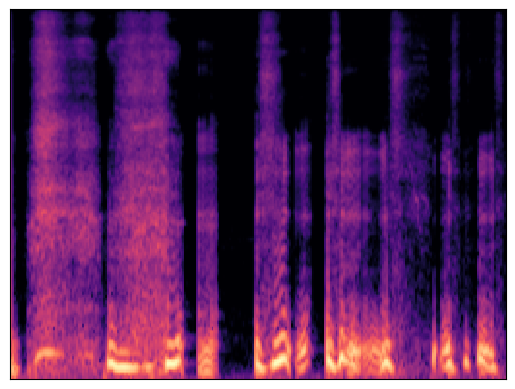

In [ ]:
test = config.out_dir + os.listdir(config.out_dir)[2]
mel = np.load(test)
print(mel.shape)
print(os.path.basename(test).split('_')[0])
librosa.display.specshow(mel)

In [ ]:
# len(os.listdir("/content/mel_spectrograms"))
# files= [f for f in os.listdir("/content/mel_spectrograms") if f.endswith('.npy')]

In [ ]:
# files[0].split('_')[1]
# filepath = os.path.join("/content/mel_spectrograms/", files[0])
# print(filepath)

In [ ]:
class NonSpeech(Dataset):
  def __init__(self, mel_dir):
    self.mel_dir = mel_dir # /content/mel_spectrograms/
    self.files = [f for f in os.listdir(self.mel_dir) if f.endswith('.npy')]

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    filename = self.files[idx]
    filepath = os.path.join(self.mel_dir, filename)
    img = np.load(filepath)
    img = torch.from_numpy(img).float()
    img = img.repeat(3, 1, 1)

    label = torch.tensor(int(filename.split('_')[1]), dtype = torch.long)

    return img, label

In [ ]:
NonSpeechDs = NonSpeech(config.out_dir)

In [ ]:
train_size = int(0.8 * len(NonSpeechDs))
val_size = len(NonSpeechDs) - train_size
NonSpeech_train, NonSpeech_val = random_split(NonSpeechDs, [train_size, val_size])

In [ ]:
batch_size=8
train_load = DataLoader(NonSpeech_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_load = DataLoader(NonSpeech_val, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
import torch.nn as nn

In [ ]:
# base = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
# print(base.classifier)


In [ ]:
class NonSpeechModel(nn.Module):
  def __init__(self, n_labels):
    super().__init__()
    base = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

    self.features = base.features
    self.avg_pool = base.avgpool
    self.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(base.classifier[1].in_features, n_labels)
    )
  def forward(self, x):
    x = self.features(x)
    x = self.avg_pool(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)

In [ ]:
model = NonSpeechModel(n_labels).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:01<00:00, 149MB/s]  


In [ ]:
# from torchsummary import summary
# summary(model, (3, 256, 256))

In [ ]:
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
!pip install torcheval


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.6 MB/s eta 0:00:00a 0:00:01


In [ ]:
from torcheval.metrics.functional import multiclass_f1_score

In [ ]:
from torch.amp import autocast, GradScaler

def train(model, train_load, optimizer, scheduler, criterion, n_epochs=25):
  losses = []
  accuracies = []
  f1_score = []
  scaler = GradScaler(device='cuda')
  for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0,0
    all_preds, all_labels=[], []

    for sample, label in tqdm(train_load, total=len(train_load)):
      sample = sample.to(device)
      label = label.to(device)

      optimizer.zero_grad()

      with autocast(device_type='cuda'):
        yhat = model(sample)
        loss = criterion(yhat, label)

      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      # loss.backward()
      # optimizer.step()

      running_loss += loss.item() * sample.size(0)

      preds = torch.argmax(yhat, dim=1)
      correct += (preds == label).sum().item()
      total += label.size(0)

      all_preds.append(preds.cpu())
      all_label.append(label.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_label)

    f1 = multiclass_f1_score(all_preds, all_label, num_classes=n_labels, average="macro")
    f1_score.append(f1.item())

    epoch_loss = running_loss / len(train_load.dataset)
    epoch_acc = correct / total

    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    scheduler.step(losses[-1])
    print(f'Epoch {epoch+1}/{n_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, F1 Score: {f1.item():.4f}')
  return losses, accuracies, f1_score

In [ ]:
losses, accuracies, f1_score = train(model, train_load, optimizer, scheduler, criterion)
losses, accuracies, f1_score

100%|██████████| 629/629 [01:38<00:00,  6.39it/s]


Epoch 1/25 - Loss: 0.7170, Accuracy: 0.7531, F1 Score: 0.6567


100%|██████████| 629/629 [01:39<00:00,  6.29it/s]


Epoch 2/25 - Loss: 0.3476, Accuracy: 0.8891, F1 Score: 0.8618


100%|██████████| 629/629 [01:38<00:00,  6.36it/s]


Epoch 3/25 - Loss: 0.2076, Accuracy: 0.9346, F1 Score: 0.9135


100%|██████████| 629/629 [01:38<00:00,  6.39it/s]


Epoch 4/25 - Loss: 0.1340, Accuracy: 0.9539, F1 Score: 0.9406


100%|██████████| 629/629 [01:38<00:00,  6.37it/s]


Epoch 5/25 - Loss: 0.0960, Accuracy: 0.9704, F1 Score: 0.9586


100%|██████████| 629/629 [01:38<00:00,  6.39it/s]


Epoch 6/25 - Loss: 0.0851, Accuracy: 0.9696, F1 Score: 0.9606


100%|██████████| 629/629 [01:38<00:00,  6.37it/s]


Epoch 7/25 - Loss: 0.0923, Accuracy: 0.9722, F1 Score: 0.9649


100%|██████████| 629/629 [01:38<00:00,  6.40it/s]


Epoch 8/25 - Loss: 0.0634, Accuracy: 0.9813, F1 Score: 0.9734


100%|██████████| 629/629 [01:38<00:00,  6.37it/s]


Epoch 9/25 - Loss: 0.0752, Accuracy: 0.9758, F1 Score: 0.9696


100%|██████████| 629/629 [01:38<00:00,  6.40it/s]


Epoch 10/25 - Loss: 0.0670, Accuracy: 0.9787, F1 Score: 0.9720


100%|██████████| 629/629 [01:38<00:00,  6.37it/s]


Epoch 11/25 - Loss: 0.0714, Accuracy: 0.9789, F1 Score: 0.9725


100%|██████████| 629/629 [01:38<00:00,  6.37it/s]


Epoch 12/25 - Loss: 0.0441, Accuracy: 0.9859, F1 Score: 0.9811


100%|██████████| 629/629 [01:38<00:00,  6.39it/s]


Epoch 13/25 - Loss: 0.0619, Accuracy: 0.9823, F1 Score: 0.9772


100%|██████████| 629/629 [01:38<00:00,  6.38it/s]


Epoch 14/25 - Loss: 0.0547, Accuracy: 0.9817, F1 Score: 0.9745


100%|██████████| 629/629 [01:38<00:00,  6.36it/s]


Epoch 15/25 - Loss: 0.0498, Accuracy: 0.9835, F1 Score: 0.9762


100%|██████████| 629/629 [01:38<00:00,  6.40it/s]


Epoch 16/25 - Loss: 0.0593, Accuracy: 0.9833, F1 Score: 0.9761


100%|██████████| 629/629 [01:38<00:00,  6.39it/s]


Epoch 17/25 - Loss: 0.0377, Accuracy: 0.9891, F1 Score: 0.9843


100%|██████████| 629/629 [01:38<00:00,  6.40it/s]


Epoch 18/25 - Loss: 0.0416, Accuracy: 0.9857, F1 Score: 0.9816


100%|██████████| 629/629 [01:39<00:00,  6.34it/s]


Epoch 19/25 - Loss: 0.0343, Accuracy: 0.9891, F1 Score: 0.9865


100%|██████████| 629/629 [01:38<00:00,  6.40it/s]


Epoch 20/25 - Loss: 0.0417, Accuracy: 0.9861, F1 Score: 0.9806


100%|██████████| 629/629 [01:38<00:00,  6.40it/s]


Epoch 21/25 - Loss: 0.0377, Accuracy: 0.9881, F1 Score: 0.9854


100%|██████████| 629/629 [01:39<00:00,  6.33it/s]


Epoch 22/25 - Loss: 0.0465, Accuracy: 0.9857, F1 Score: 0.9816


100%|██████████| 629/629 [01:39<00:00,  6.32it/s]


Epoch 23/25 - Loss: 0.0446, Accuracy: 0.9879, F1 Score: 0.9864


100%|██████████| 629/629 [01:40<00:00,  6.29it/s]


Epoch 24/25 - Loss: 0.0541, Accuracy: 0.9841, F1 Score: 0.9758


100%|██████████| 629/629 [01:41<00:00,  6.21it/s]


Epoch 25/25 - Loss: 0.0315, Accuracy: 0.9911, F1 Score: 0.9851


([0.7170175257111325,
  0.3476450884290065,
  0.20758011723886877,
  0.13400410939414514,
  0.09598487123618944,
  0.08506559131619258,
  0.09233695291196718,
  0.06343351444037425,
  0.07518357236424797,
  0.06698751376722992,
  0.07142661399050845,
  0.044094111283910324,
  0.061872081286576563,
  0.054722065836597694,
  0.049786343367996526,
  0.05926057473017283,
  0.03770942366388583,
  0.041595257648391434,
  0.034268928390004436,
  0.041676589615289084,
  0.037672237405861494,
  0.04645214657071712,
  0.044613398998069424,
  0.05410866248283459,
  0.03150396727586783],
 [0.7531305903398927,
  0.889087656529517,
  0.9346054462333532,
  0.9538859073742795,
  0.9703836215464122,
  0.9695885509838998,
  0.9721725303120652,
  0.9813158417809581,
  0.9757503478433711,
  0.9787318624527926,
  0.9789306300934207,
  0.9858874975154045,
  0.9823096799840986,
  0.9817133770622143,
  0.9835022858278673,
  0.9833035181872392,
  0.9890677797654542,
  0.9856887298747764,
  0.9890677797654542,


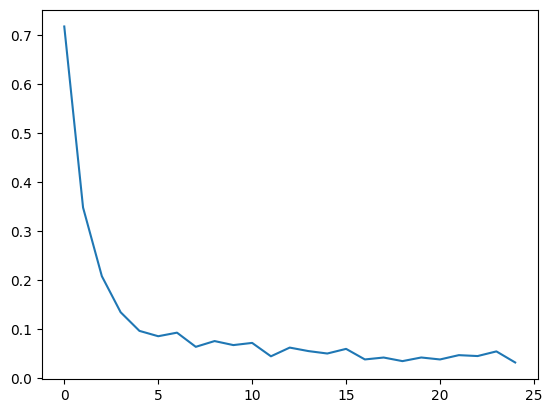

In [ ]:
plt.plot(losses)
plt.show()

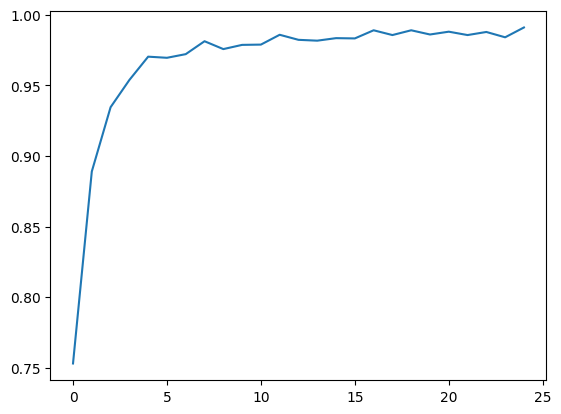

In [ ]:
plt.plot(accuracies)
plt.show()

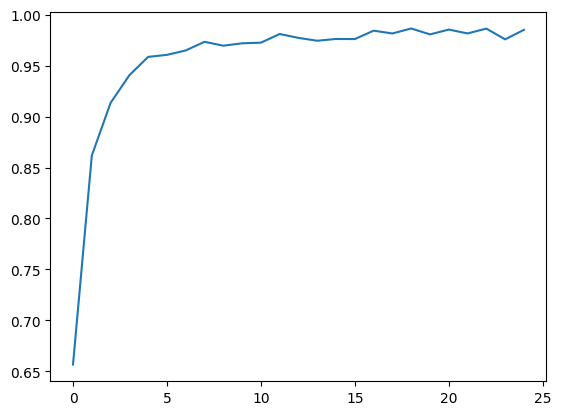

In [ ]:
plt.plot(f1_score)
plt.show()

In [ ]:
!du -sh mel_spectrograms/

1.6G	mel_spectrograms/


In [ ]:
def evaluate(model, val_load, criterion):
  model.eval()
  running_loss = 0.0
  correct, total = 0, 0
  all_preds, all_labels = [], []
  with torch.no_grad():
    for sample, label in tqdm(val_load, total = len(val_load)):
      sample = sample.to(device)
      label = label.to(device)

      with autocast(device_type='cuda'):
        yhat = model(sample)
        loss = criterion(yhat, label)

      running_loss += loss.item() * sample.size(0)
      preds = torch.argmax(yhat, dim=1)
      correct += (preds == label).sum().item()
      total += label.size(0)
      all_preds.append(preds.cpu())
      all_labels.append(label.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    f1_score = multiclass_f1_score(all_preds, all_labels, num_classes=n_labels, average="macro")
    val_loss = running_loss / len(val_load.dataset)
    val_acc = correct / total
  return val_loss, val_acc, f1_score.item()

loss, accuracy, f1_score = evaluate(model, val_load, criterion)

100%|██████████| 158/158 [00:07<00:00, 22.17it/s]


In [ ]:
print(loss, accuracy, f1_score)

0.2272839984946865 0.9467408585055644 0.9240623116493225


In [ ]:
torch.save(model.state_dict(), "NonSpeech7kModel_01.pth")